In [3]:
%matplotlib inline
import numpy as np
import pyneb as pn
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
oiir = pn.RecAtom("O", 2)

In [7]:
oiiic = pn.Atom("O", 3)

In [13]:
oiiic.getTransition(5007)

(4, 3)

In [18]:
pn.atomicData.getDataFile('O2', 'rec')

'o_ii_rec_SSB17-B-opt.hdf5'

In [19]:
pn.atomicData.getAllAtoms(coll=False, rec=True)

['H1',
 'He1',
 'He2',
 'C1',
 'C2',
 'C3',
 'C4',
 'N1',
 'N2',
 'N3',
 'N4',
 'Ne2',
 'O1',
 'O2',
 'O3',
 'O4',
 'O5',
 'N5',
 'O6']

In [78]:
[_ for _ in oiir.labels if _.startswith("43")]

['4312.11',
 '4313.44',
 '4315.35',
 '4315.83',
 '4322.45',
 '4342.00',
 '4303.61',
 '4315.38',
 '4309.00',
 '4324.79',
 '4315.69',
 '4315.39',
 '4309.01',
 '4371.24',
 '4340.32',
 '4331.16',
 '4371.61',
 '4332.69',
 '4374.32',
 '4343.36',
 '4335.36',
 '4334.18',
 '4343.50',
 '4334.32',
 '4334.03',
 '4327.58',
 '4307.23',
 '4384.70',
 '4353.59',
 '4345.55',
 '4344.37',
 '4354.21',
 '4346.17',
 '4344.99',
 '4305.39',
 '4397.82',
 '4366.53',
 '4358.44',
 '4357.25',
 '4303.82',
 '4366.80',
 '4358.71',
 '4357.22',
 '4317.70',
 '4304.08',
 '4395.93',
 '4369.27',
 '4347.41',
 '4347.22',
 '4351.26',
 '4349.43',
 '4319.63',
 '4366.89',
 '4336.86',
 '4317.14',
 '4345.56',
 '4325.76']

In [22]:
oiir.getTransition('4649.13')

In [30]:
oiir.getEmissivity(tem=np.linspace(5000, 10000, 6), den=1e4, label='4650.84')

array([2.55475947e-25, 2.20488455e-25, 1.94683724e-25, 1.74965871e-25,
       1.58873720e-25, 1.46000000e-25])

In [74]:
temperatures = np.geomspace(3000.0, 100_000.0, 200)

In [58]:
V1_mult = ('4638.86', '4641.81', '4649.13', '4650.84', '4661.63', '4673.73', '4676.23', '4696.35')
def oii_multiplet_sum_emissivity(tem, den, multiplet=V1_mult):
    result = None
    for label in multiplet:
        em = oiir.getEmissivity(tem=tem, den=den, label=label)
        if result is None:
            result = em
        else:
            result += em
    return result


def normalize(tem, em, T0=8000.0):
    # Normalize to T = T0
    em0 = np.interp(T0, tem, em)
    return em / em0

In [93]:
V15_mult = "4590.97", #"4596.18", "4595.96"
V3d_4f = "4303.82", "4609.44", "4087.15", "4089.29"

In [71]:
oii_multiplet_sum_emissivity([1000, 3000, 5000, 8000, 1e4], 1e4, multiplet=V15_mult)

array([1.12900000e-25, 2.22026735e-25, 1.95540308e-25, 1.57714028e-25,
       1.38500000e-25])

In [103]:
sns.set_context("poster")
sns.set_color_codes("bright")

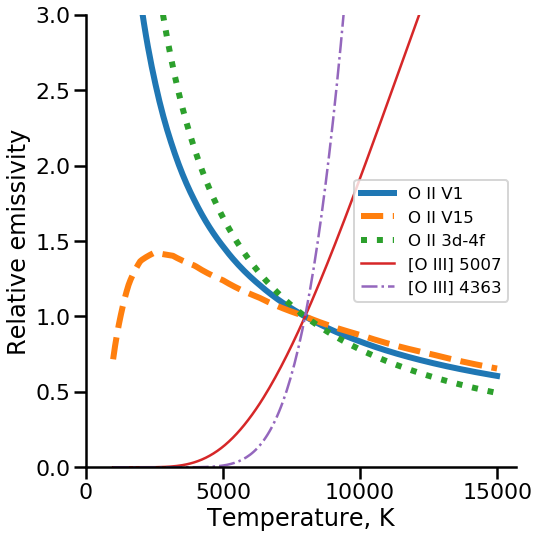

In [114]:
fig, ax = plt.subplots(figsize=(8, 8))
density = 1e4

em = oii_multiplet_sum_emissivity(temperatures, density)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II V1", ls="-", lw=6)

em = oii_multiplet_sum_emissivity(temperatures, density, multiplet=V15_mult)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II V15", ls="--", lw=6)

em = oii_multiplet_sum_emissivity(temperatures, density, multiplet=V3d_4f)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II 3d-4f", ls=":", lw=6)

em = oiiic.getEmissivity(tem=temperatures, den=density, wave=5007)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="[O III] 5007", ls="-", lw=2.5)

em = oiiic.getEmissivity(tem=temperatures, den=density, wave=4363)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="[O III] 4363", ls="-.", lw=2.5)

ax.legend(fontsize="x-small")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[1e-2, None],
    xlim=[None, None],
    xlabel="Temperature, K",
    ylabel="Relative emissivity",
)
sns.despine()
fig.tight_layout()
fig.savefig("oplusplus-emissivity-vs-t-loglog.pdf")

In [41]:
oiiic.getEmissivity?